In [ ]:
!pip install botorch
!pip install brian2

# Import

In [71]:
# --- Jupyter setup ---
%load_ext autoreload
%autoreload 2

# --- System path setup ---
import os
import sys
sys.path.append(os.getcwd())

# Verify the current directory
print("Current directory:", os.getcwd())

# --- Environment settings ---
nrn_options = "-nogui -NSTACK 100000 -NFRAME 20000"
os.environ["NEURON_MODULE_OPTIONS"] = nrn_options

# --- Core Python libraries ---
import math
import time
import warnings
from dataclasses import dataclass
from functools import partial
import pandas as pd

# --- NumPy & Matplotlib ---
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.animation as animation

# --- Skopt (Bayesian optimization) ---
from skopt import gp_minimize
from skopt.space import Real
from skopt.plots import plot_gaussian_process, plot_convergence

# --- PyTorch & GPyTorch ---
import torch
from torch import nn
from torch.quasirandom import SobolEngine

import gpytorch
from gpytorch.constraints import Interval
from gpytorch.kernels import MaternKernel, RBFKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood

# --- BoTorch ---
from botorch import manual_seed
from botorch.acquisition import LogExpectedImprovement, qExpectedImprovement, qLogExpectedImprovement
from botorch.exceptions import BadInitialCandidatesWarning
from botorch.fit import fit_gpytorch_mll
from botorch.generation import MaxPosteriorSampling
from botorch.models import SingleTaskGP
from botorch.models.gp_regression import SingleTaskGP as STGP
from botorch.models.kernels import InfiniteWidthBNNKernel
from botorch.models.transforms.outcome import Standardize
from botorch.optim import optimize_acqf
from botorch.optim.optimize import optimize_acqf as optimize_acqf_fn
from botorch.test_functions import Ackley
from botorch.utils.sampling import draw_sobol_samples
from botorch.utils.transforms import unnormalize

# --- Brian2 ---
from brian2 import *

# --- Custom Utilities ---
from utils.sim_utils import set_params_utils, eqs_utils, plotting_utils, obj_func_utils, set_param_space
from utils.methods_utils import ibnn_utils, shared_utils, turbo_utils, baseline_bo_utils, cma_utils
from utils.training_utils import prep_for_training

# --- Warning filters ---
warnings.filterwarnings("ignore", category=BadInitialCandidatesWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
np.set_printoptions(suppress=True)
torch.set_printoptions(sci_mode=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Current directory: /Users/dusiyi/Downloads/Pulkit_class/final_project/selective_stimulation


# Set up simulation environment

## initial simulation

Current directory: /Users/dusiyi/Downloads/Pulkit_class/final_project/selective_stimulation
Starting simulation at t=0. s for a duration of 6.1 s
1.9166 s (31%) simulated in 10s, estimated 22s remaining.
4.0935 s (67%) simulated in 20s, estimated 10s remaining.
6.1 s (100%) simulated in 27s


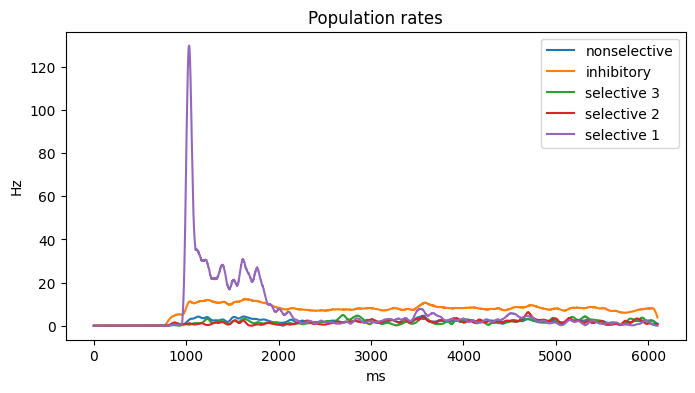

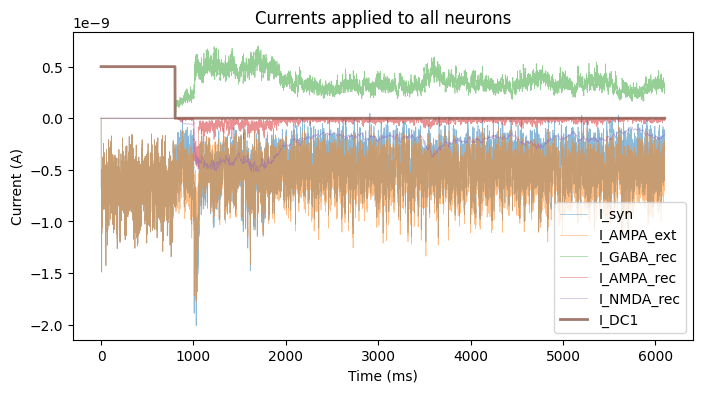

In [2]:
from utils.training_utils.set_train_env import*

In [3]:
pls_stop 
# go to BP-IBNN

NameError: name 'pls_stop' is not defined

## test obj func

In [ ]:
DC_start_time1 = 1000  # in ms
DC_duration1 = 300  # in ms
DC_amp1 = 0.1  # in nA
DC_amp_slope1 = 0.001  # in nA/ms

# DC_start_time2 = 200  # in ms
# DC_duration2 = 1000  # in ms
# DC_amp2 = -0.05  # in nA
# DC_amp_slope2 = -0.001  # in nA/ms

# sino_start_time1 = 0  # in ms
# sino_duration1=1000  # in ms
# sino_amp1=0.5  # in nA
# sino_freq1=20  # in Hz

# sino_start_time2 = 1000  # in ms
# sino_duration2=500  # in ms
# sino_amp2=0.2  # in nA
# sino_freq2=10  # in Hz


# make sure that we can run the below with no bugs
params = [DC_start_time1, DC_duration1, DC_amp1, DC_amp_slope1,
        #  DC_start_time2, DC_duration2, DC_amp2, DC_amp_slope2, 
        #   sino_start_time1, sino_duration1, sino_amp1, sino_freq1,
        #   sino_start_time2, sino_duration2, sino_amp2, sino_freq2
          ]

stim_bounds_array = np.array(stim_bounds)
params_norm = (np.array(params) - stim_bounds_array[0,:]) / (stim_bounds_array[1,:] - stim_bounds_array[0,:])

objective_with_factor(params_norm)

Objective function called with params:  [0.5        0.04682274 0.66666666 0.5025    ]
DC_amp1: 0.1, DC_amp_slope1: 0.001, DC_start_time1: 1000.0, DC_duration1: 300.0
Persistent activity of pop1 after 1100 ms : 379.49999999999994 ms
Value to minimize: -379.5. Normalized value: -0.0759


-0.0759

## rerun (optional)

In [ ]:
#title_prefix = f'sino_amp2 = {sino_amp2} nA: '
title_prefix = ''
net.restore('initial')

DC_input_ts = 1 * ms
sino_input_ts = 0.1 * ms

DC_start_time1 = 0  # in ms
DC_duration1 = 1000  # in ms
DC_amp1 = 0.1  # in nA
DC_amp_slope1 = 0.001  # in nA/ms

DC_start_time2 = 500  # in ms
DC_duration2 = 2000  # in ms
DC_amp2 = -0.05  # in nA
DC_amp_slope2 = 0.001  # in nA/ms

# sino_start_time1 = 0  # in ms
# sino_duration1=3000  # in ms
# sino_amp1=0.08  # in nA
# sino_freq1=5  # in Hz

# sino_start_time2 = 1000  # in ms
# sino_duration2=2000  # in ms
# sino_amp2=0.06  # in nA
# sino_freq2=10  # in Hz


DC_input1 = set_params_utils.set_DC_input(DC_amp=DC_amp1, # in nA
            DC_duration=DC_duration1, # in ms
            DC_start_time=DC_start_time1, # in ms
            timestep=DC_input_ts
            )

# DC_input2 = set_params_utils.set_DC_input(DC_amp=DC_amp2, # in nA
#             DC_duration=DC_duration2, # in ms
#             DC_start_time=DC_start_time2, # in ms
#             timestep=DC_input_ts
#             )

# sino_input1 = set_params_utils.set_sino_input(sino_start_time=sino_start_time1, # in ms
#                 sino_duration=sino_duration1, # in ms
#                 sino_amp=sino_amp1, # in nA
#                 sino_freq=sino_freq1, # in Hz
#                 timestep=sino_input_ts
#                 )

# sino_input2 = set_params_utils.set_sino_input(sino_start_time=sino_start_time2, # in ms
#                 sino_duration=sino_duration2, # in ms
#                 sino_amp=sino_amp2, # in nA
#                 sino_freq=sino_freq2, # in Hz
#                 timestep=sino_input_ts
#                 )



net.run(6.1 * second, report='stdout')
plotting_utils.plot_firing_rate(r_E, r_I, r_E_sels, title_prefix=title_prefix)
# plotting_utils.plot_currents(current_monitor_E, current_monitor_I, currents_to_plot, E_index_map, title_prefix=title_prefix)

plotting_utils.plot_currents(current_monitor_E, None, ['I_DC1'], E_index_map, title_prefix='')
plt.gcf().subplots_adjust(left=0.25)


In [ ]:
t_in_window, rate_in_window, mean_fr = obj_func_utils.calculate_fr_in_window(r_E_sels[0])

## see effect of smoothing width

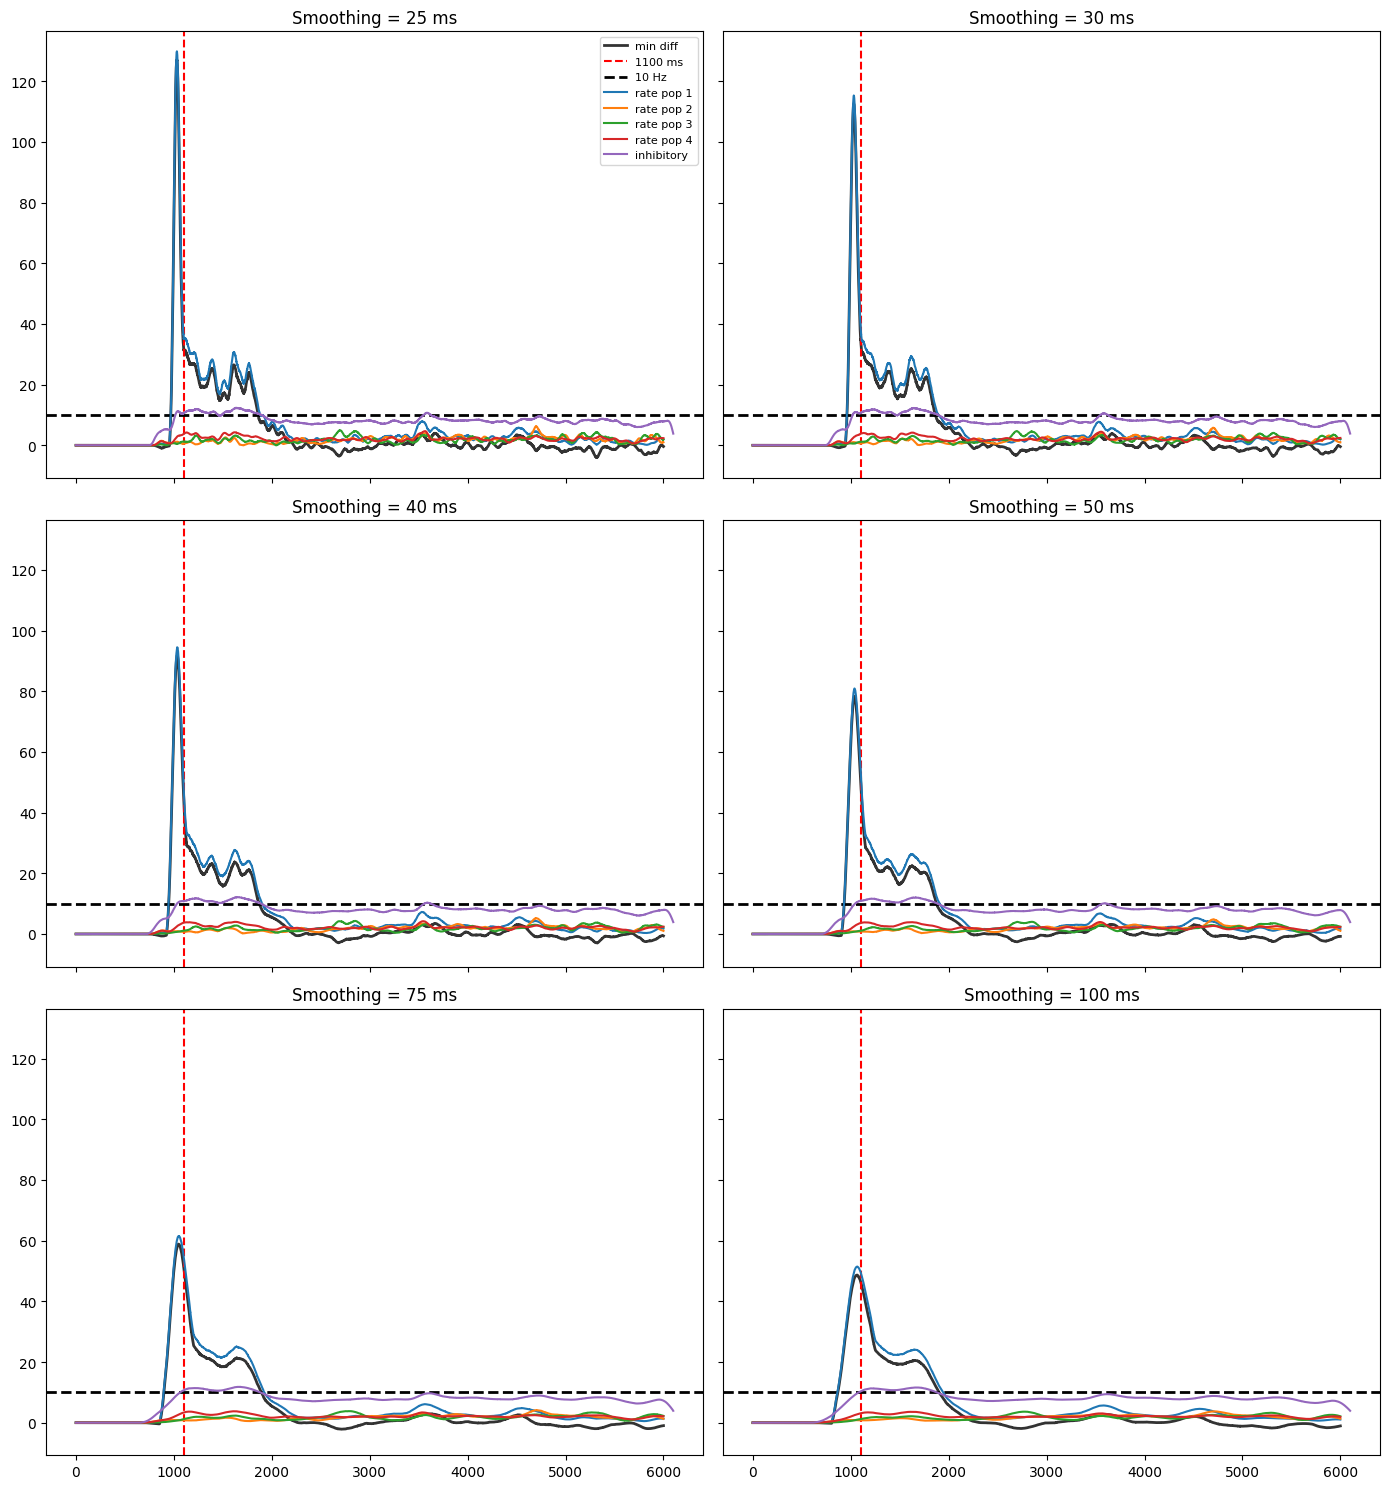

In [ ]:
# Settings
fr_window = [0, 6000]
smoothing_widths = [25, 30, 40, 50, 75, 100]  # in ms
num_rows = 3
num_cols = 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 7, num_rows * 5), sharex=True, sharey=True)
axes = axes.flatten()

for idx, width in enumerate(smoothing_widths):
    if idx >= len(axes):
        break  # prevent index error if grid is too small

    ax = axes[idx]
    smoothing_width = width * ms

    # Compute firing rates
    t_in_window, rates_sel = [], []
    for i in range(3):
        t, rate, _ = obj_func_utils.calculate_fr_in_window(
            r_E_sels[i], fr_window=fr_window, smoothing_width=smoothing_width)
        t_in_window = t  # assume same for all
        rates_sel.append(rate)

    _, rate_non_sel, _ = obj_func_utils.calculate_fr_in_window(
        r_E, fr_window=fr_window, smoothing_width=smoothing_width)

    # Differences
    diff_12 = rates_sel[0] - rates_sel[1]
    diff_13 = rates_sel[0] - rates_sel[2]
    diff_14 = rates_sel[0] - rate_non_sel
    min_diff = np.minimum.reduce([diff_12, diff_13, diff_14])

    # Plot
    ax.plot(t_in_window / ms, min_diff, label='min diff', linewidth=2, color='black', alpha=0.8)
    ax.axvline(x=1100, color='r', linestyle='--', label='1100 ms')
    ax.axhline(y=10, color='black', linestyle='--', linewidth=2, label='10 Hz')
    ax.plot(t_in_window / ms, rates_sel[0], label='rate pop 1')
    ax.plot(t_in_window / ms, rates_sel[1], label='rate pop 2')
    ax.plot(t_in_window / ms, rates_sel[2], label='rate pop 3')
    ax.plot(t_in_window / ms, rate_non_sel, label='rate pop 4')
    ax.plot(r_I.t / ms, r_I.smooth_rate(width=smoothing_width) / Hz, label='inhibitory')
    ax.set_title(f'Smoothing = {width} ms')

    if idx == 0:
        ax.legend(fontsize=8)

plt.tight_layout()
plt.show()


In [ ]:
# for width in [25, 50, 75, 100]:
#     smoothing_width=width * ms
#     print(f"Smoothing width: {smoothing_width}")
#     plotting_utils.plot_firing_rate(r_E, r_I, r_E_sels, smoothing_width=smoothing_width)

# Train all methods

In [ ]:
# np.random.seed(237)

## Get shared initial points

In [ ]:
objective_func_tensor_temp = partial(obj_func_utils.objective_function, net=net, namespace=namespace, stim_bounds=stim_bounds, current_monitor_E=current_monitor_E, r_E=r_E, r_I=r_I, r_E_sels=r_E_sels,
                                process_input_func=obj_func_utils.process_input_tensor, process_output_func=obj_func_utils.process_output_tensor, E_index_map=E_index_map,
                                maximize=True, plotting=True)

In [ ]:
init_x, init_y = ibnn_utils.generate_initial_data(objective_func_tensor_temp, stim_bounds_norm, n=20)
result_folder = shared_utils.get_new_result_subfolder(result_dir='all_stored_results/init_points')
if not os.path.exists(result_folder):
    os.makedirs(result_folder)
torch.save(init_x, os.path.join(result_folder, "updated_x.pt"))
torch.save(init_y, os.path.join(result_folder, "updated_y.pt"))

## BO - IBNN

https://botorch.org/docs/tutorials/ibnn_bo/

Infinite-Width Bayesian Neural Networks for Bayesian Optimization

In this tutorial, we present an overview of infinite-width Bayesian neural networks (I-BNNs) [1, 2] and show how to use them as surrogate models for Bayesian optimization (BO).

Consider an fully connected neural network with $L$ hidden layers, parameter weights drawn from $\mathcal{N(0, \sigma_w)}$, bias terms drawn from $\mathcal{N(0, \sigma_b)}$, and nonlinearity $\phi$. In the infinite-width limit, the output of this network is exactly equivalent to $\mathcal{GP}(\mu, K^L)$. By the central limit theorem, we find $\mu(x) = 0$, and we can also recursively define the covariance function as
$$K^0(x, x')=\sigma_b^2+\sigma_w^2\frac{x \cdot x'}{d_\text{input}}\qquad K^l(x, x')=\sigma_b^2+\sigma_w^2F_\phi(K^{l-1}(x, x'), K^{l-1}(x, x), K^{l-1}(x', x'))$$
where $F_\phi$ is a deterministic function based on the activation function $\phi$.

We will refer to this kernel as the "I-BNN kernel". Unlike many popular GP kernels, I-BNN covariance function is not based on Euclidean distance, allowing the GP to represent nonstationary functions. This is advantageous for many settings of Bayesian optimization, since the function we want to optimize may not have similar behavior throughout the entire input space. Furthermore, I-BNNs have been shown to work particularly well for BO problems with high-dimensional inputs [3].

BoTorch has an implementation of I-BNNs with ReLU activations: `InfiniteWidthBNNKernel`.


[1] [Y. Cho, and L. Saul. Kernel Methods for Deep Learning. Advances in Neural Information Processing Systems 22, 2009.](https://papers.nips.cc/paper_files/paper/2009/hash/5751ec3e9a4feab575962e78e006250d-Abstract.html)  
[2] [J. Lee, Y. Bahri, R. Novak, S. Schoenholz, J. Pennington, and J. Dickstein. Deep Neural Networks as Gaussian Processes. International Conference on Learning Representations 2018.](https://arxiv.org/abs/1711.00165)  
[3] [Y.L. Li, T.G.J. Rudner, A.G. Wilson. A Study of Bayesian Neural Network Surrogates for Bayesian Optimization. International Conference on Learning Representations 2024.](https://arxiv.org/abs/2305.20028)

In [ ]:
optimize_hypers = True
N_ITERATIONS = 200
network_depth = 3
result_dir = 'all_stored_results/ibnn_results/optimize_hypers'

# --- get initial data ---
init_x, init_y = prep_for_training.get_init_x_and_y()

# --- Environment settings ---
nrn_options = "-nogui -NSTACK 100000 -NFRAME 20000"
os.environ["NEURON_MODULE_OPTIONS"] = nrn_options
warnings.filterwarnings('ignore')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- define kernels ---
ibnn_kernel = InfiniteWidthBNNKernel(network_depth, device=device)
ibnn_kernel.weight_var = 10.0
ibnn_kernel.bias_var = 5.0
ibnn_kernel = ScaleKernel(ibnn_kernel, device=device)

# --- run BO loop ---
acqf_classes = {"LogEI": LogExpectedImprovement}
results = {}
for acq_name, acqf_class in acqf_classes.items():
    run_bo_with_acqf = partial(ibnn_utils.gp_bo_loop, f=objective_func_tensor, bounds=stim_bounds_norm, acqf_class=acqf_class, 
                               result_dir=result_dir,
                               init_x=init_x, 
                               init_y=init_y, 
                               n_iterations=N_ITERATIONS,
                               )
    ibnn_x, ibnn_y = run_bo_with_acqf(kernel=ibnn_kernel, optimize_hypers=optimize_hypers)
    # matern_x, matern_y = run_bo_with_acqf(kernel=matern_kernel, optimize_hypers=True)
    # rbf_x, rbf_y = run_bo_with_acqf(kernel=rbf_kernel, optimize_hypers=True)
    results[acq_name] = {
        "BNN": (ibnn_x, ibnn_y),
        # "Matern": (matern_x, matern_y),
        # "RBF": (rbf_x, rbf_y),
    }


Objective function called with params:  tensor([[0., 0., 1., 1.]])
DC_amp1: 0.3, DC_amp_slope1: 0.2, DC_start_time1: 0.0, DC_duration1: 20.0
Persistent activity of pop1 after 1100 ms : 570.2 ms
570.2 (value to maximize)
0.11404 (Normalized value)
Iteration 0: total runtime is 35.00 s
Maximum value so far: 0.37934
Saved updated_x.pt and updated_y.pt in the folder all_stored_results/ibnn_results/optimize_hypers/temp_results
Number of training points: 21
Objective function called with params:  tensor([[1., 1., 1., 1.]])
DC_amp1: 0.3, DC_amp_slope1: 0.2, DC_start_time1: 2000.0, DC_duration1: 6000.0
Persistent activity of pop1 after 1100 ms : 459.79999999999995 ms
459.8 (value to maximize)
0.09196 (Normalized value)
Iteration 1: total runtime is 71.34 s
Maximum value so far: 0.37934
Saved updated_x.pt and updated_y.pt in the folder all_stored_results/ibnn_results/optimize_hypers/temp_results
Number of training points: 22
Objective function called with params:  tensor([[1., 1., 1., 1.]])
DC_

In [ ]:
optimize_hypers = False
N_ITERATIONS = 200
network_depth = 3
result_dir = 'all_stored_results/ibnn_results'

# --- get initial data ---
init_x, init_y = prep_for_training.get_init_x_and_y()

# --- Environment settings ---
nrn_options = "-nogui -NSTACK 100000 -NFRAME 20000"
os.environ["NEURON_MODULE_OPTIONS"] = nrn_options
warnings.filterwarnings('ignore')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- define kernels ---
ibnn_kernel = InfiniteWidthBNNKernel(network_depth, device=device)
ibnn_kernel.weight_var = 10.0
ibnn_kernel.bias_var = 5.0
ibnn_kernel = ScaleKernel(ibnn_kernel, device=device)

# --- run BO loop ---
acqf_classes = {"LogEI": LogExpectedImprovement}
results = {}
for acq_name, acqf_class in acqf_classes.items():
    run_bo_with_acqf = partial(ibnn_utils.gp_bo_loop, f=objective_func_tensor, bounds=stim_bounds_norm, acqf_class=acqf_class, 
                               result_dir=result_dir,
                               init_x=init_x, 
                               init_y=init_y, 
                               n_iterations=N_ITERATIONS,
                               )
    ibnn_x, ibnn_y = run_bo_with_acqf(kernel=ibnn_kernel, optimize_hypers=optimize_hypers)
    # matern_x, matern_y = run_bo_with_acqf(kernel=matern_kernel, optimize_hypers=True)
    # rbf_x, rbf_y = run_bo_with_acqf(kernel=rbf_kernel, optimize_hypers=True)
    results[acq_name] = {
        "BNN": (ibnn_x, ibnn_y),
        # "Matern": (matern_x, matern_y),
        # "RBF": (rbf_x, rbf_y),
    }


In [ ]:
# %run train/train_ibnn.py

## BO with TuRBO-1 and TS/qEI

In this tutorial, we show how to implement Trust Region Bayesian Optimization (TuRBO) [1] in a closed loop in BoTorch.

This implementation uses one trust region (TuRBO-1) and supports either parallel expected improvement (qEI) or Thompson sampling (TS). We optimize the $20D$ Ackley function on the domain $[-5, 10]^{20}$ and show that TuRBO-1 outperforms qEI as well as Sobol.

Since botorch assumes a maximization problem, we will attempt to maximize $-f(x)$ to achieve $\max_x -f(x)=0$.

[1]: [Eriksson, David, et al. Scalable global optimization via local Bayesian optimization. Advances in Neural Information Processing Systems. 2019](https://proceedings.neurips.cc/paper/2019/file/6c990b7aca7bc7058f5e98ea909e924b-Paper.pdf)

Code is modified from:
https://botorch.org/docs/tutorials/baxus/

In [ ]:
for num_run in range(5):
    init_x, init_y = ibnn_utils.generate_initial_data(objective_func_tensor_temp, stim_bounds_norm, n=20)
    result_folder = shared_utils.get_new_result_subfolder(result_dir='all_stored_results/init_points')
    if not os.path.exists(result_folder):
        os.makedirs(result_folder)
    torch.save(init_x, os.path.join(result_folder, "updated_x.pt"))
    torch.save(init_y, os.path.join(result_folder, "updated_y.pt"))


    dim = len(space)

    batch_size = 2
    N_ITERATIONS = 200
    max_cholesky_size = float("inf")  # Always use Cholesky

    result_dir = 'all_stored_results/turbo_results'

    init_x, init_y = prep_for_training.get_init_x_and_y()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    dtype = torch.double

    state = turbo_utils.TurboState(dim=dim, batch_size=batch_size)

    X_turbo, Y_turbo = turbo_utils.run_turbo_loop(init_x, init_y, objective_func_tensor, dim,
                    max_iter=N_ITERATIONS, batch_size=batch_size,
                    max_cholesky_size=max_cholesky_size, device=device, dtype=dtype,
                    result_dir=result_dir,
                    )

In [ ]:
# dim = len(space)

# batch_size = 2
# N_ITERATIONS = 200
# max_cholesky_size = float("inf")  # Always use Cholesky

# result_dir = 'all_stored_results/turbo_results'

# init_x, init_y = prep_for_training.get_init_x_and_y()

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# dtype = torch.double

# state = turbo_utils.TurboState(dim=dim, batch_size=batch_size)

# X_turbo, Y_turbo = turbo_utils.run_turbo_loop(init_x, init_y, objective_func_tensor, dim,
#                    max_iter=N_ITERATIONS, batch_size=batch_size,
#                    max_cholesky_size=max_cholesky_size, device=device, dtype=dtype,
#                    result_dir=result_dir,
#                    )

In [ ]:
pls_stop

## baseline BO

In [ ]:
init_x, init_y = prep_for_training.get_init_x_and_y()
init_y = - init_y # because we are minimizing

In [ ]:
result_dir = 'all_stored_results/bo_results'

init_x, init_y = prep_for_training.get_init_x_and_y()
init_y = - init_y # because we are minimizing
N_ITERATIONS = 200

def print_iteration(res):
    print(f"Iteration {len(res.x_iters)} | Best so far: {res.fun:.4f}")

res = gp_minimize(objective_with_factor, # the function to minimize
                  space_norm,
                  x0=init_x.tolist(),
                  y0=init_y.reshape(-1).numpy().tolist(),
                  acq_func="EI",      # the acquisition function
                  n_calls=N_ITERATIONS,         # the number of evaluations of f
                  n_random_starts=5,  # the number of random initialization points
                  noise='gaussian',       # the noise level (optional)
                  callback=[print_iteration],
                  #random_state=1234
                  )   # the random seed


train_x, train_y = baseline_bo_utils.save_bo_results(res, result_dir=result_dir)

In [ ]:
pls_stop

# Show best results of all methods

## IBNN

Note: the output is unnormalized by multiplying by the factor: 5000
Top 1 parameters: tensor([0.7466, 0.8886, 0.6650, 0.7606], dtype=torch.float64)
Top 1 values: tensor([1896.7000], dtype=torch.float64)
Objective function called with params:  tensor([0.7466, 0.8886, 0.6650, 0.7606], dtype=torch.float64)
DC_amp1: 0.09901, DC_amp_slope1: 0.10424, DC_start_time1: 1493.12, DC_duration1: 5333.7084
Persistent activity of pop1 after 1100 ms : 1770.6000000000001 ms


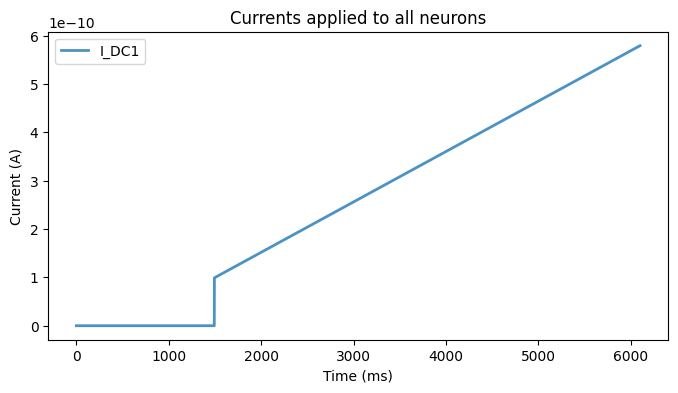

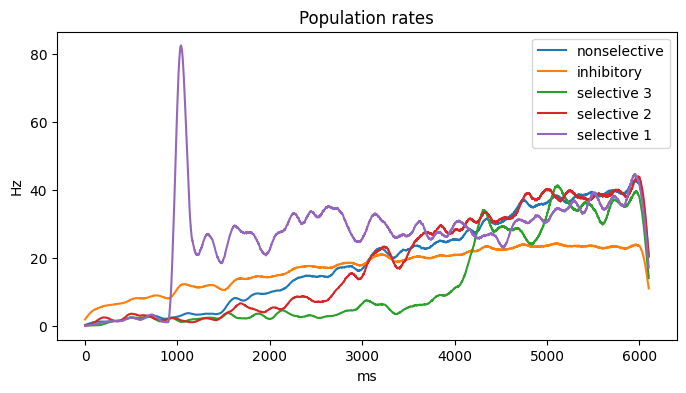

1770.6 (value to maximize)
0.35412 (Normalized value)
Top 2 parameters: tensor([0.2816, 0.2832, 0.6560, 0.5509], dtype=torch.float64)
Top 2 values: tensor([1347.7000], dtype=torch.float64)
Objective function called with params:  tensor([0.2816, 0.2832, 0.6560, 0.5509], dtype=torch.float64)
DC_amp1: 0.09363, DC_amp_slope1: 0.02034, DC_start_time1: 563.2, DC_duration1: 1713.5958
Persistent activity of pop1 after 1100 ms : 1246.1 ms


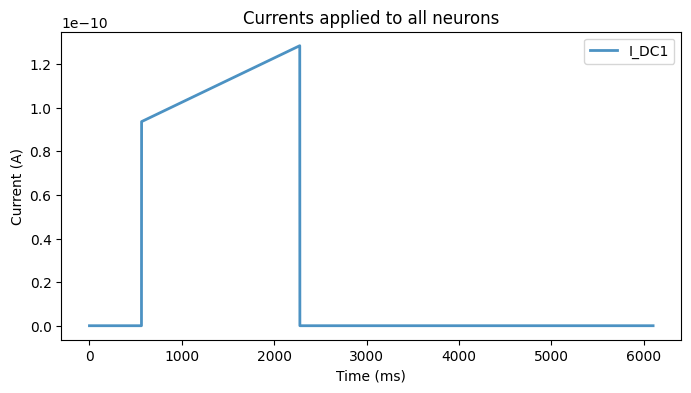

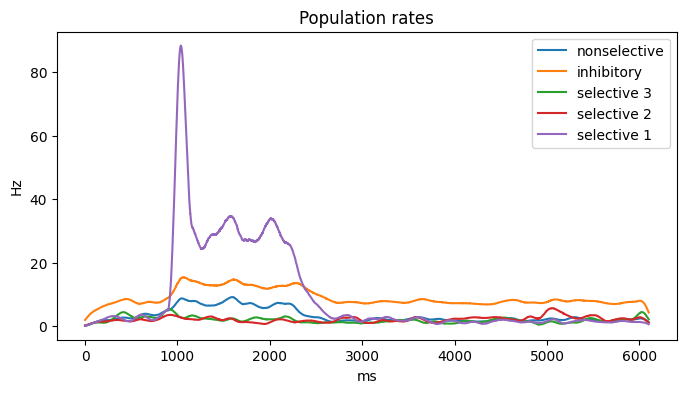

1246.1 (value to maximize)
0.24922 (Normalized value)
Top 3 parameters: tensor([1., 1., 1., 1.], dtype=torch.float64)
Top 3 values: tensor([1337.0000], dtype=torch.float64)
Objective function called with params:  tensor([1., 1., 1., 1.], dtype=torch.float64)
DC_amp1: 0.3, DC_amp_slope1: 0.2, DC_start_time1: 2000.0, DC_duration1: 6000.0
Persistent activity of pop1 after 1100 ms : 304.5 ms


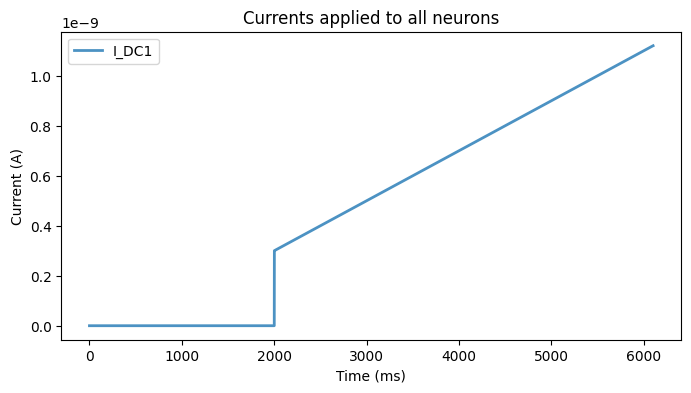

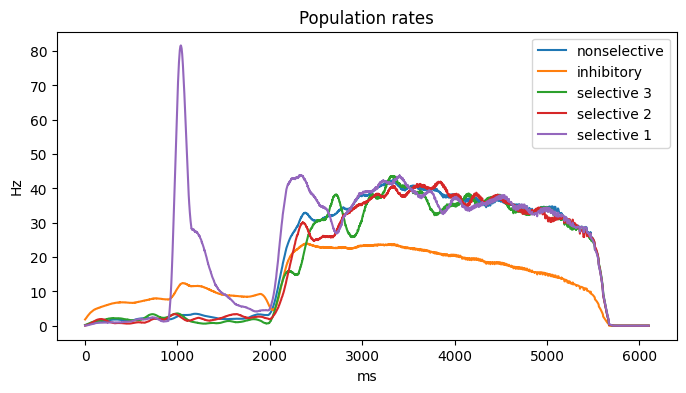

304.5 (value to maximize)
0.0609 (Normalized value)
Top 4 parameters: tensor([1., 1., 1., 1.], dtype=torch.float64)
Top 4 values: tensor([1334.9000], dtype=torch.float64)
Objective function called with params:  tensor([1., 1., 1., 1.], dtype=torch.float64)
DC_amp1: 0.3, DC_amp_slope1: 0.2, DC_start_time1: 2000.0, DC_duration1: 6000.0
Persistent activity of pop1 after 1100 ms : 199.7 ms


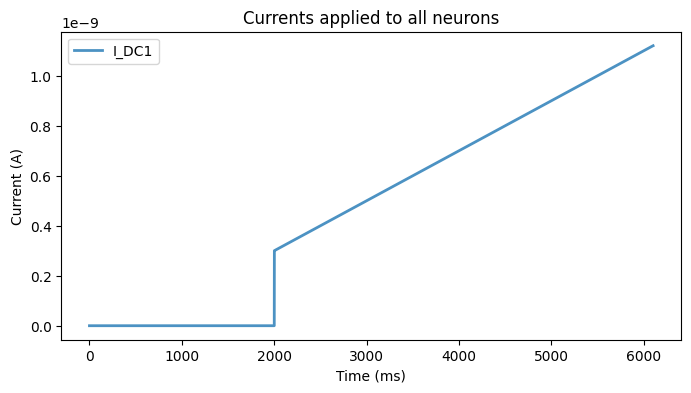

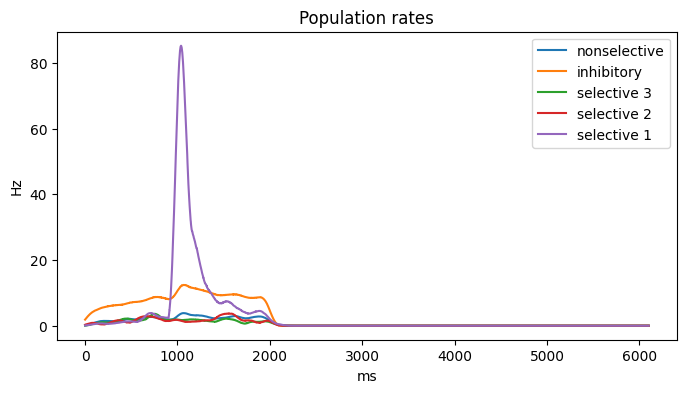

199.7 (value to maximize)
0.03994 (Normalized value)
Top 5 parameters: tensor([1., 1., 1., 1.], dtype=torch.float64)
Top 5 values: tensor([1326.8000], dtype=torch.float64)
Objective function called with params:  tensor([1., 1., 1., 1.], dtype=torch.float64)
DC_amp1: 0.3, DC_amp_slope1: 0.2, DC_start_time1: 2000.0, DC_duration1: 6000.0
Persistent activity of pop1 after 1100 ms : 1152.0 ms


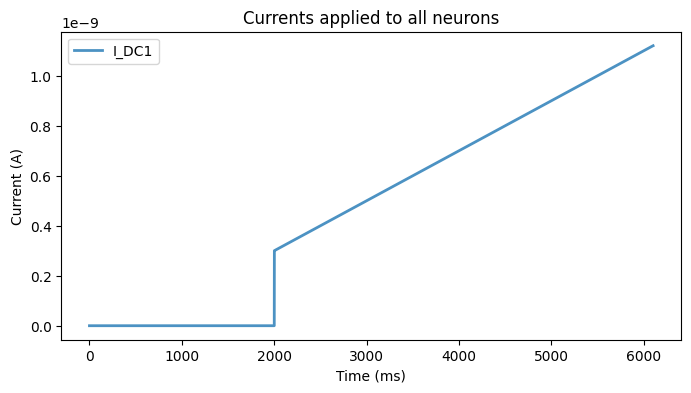

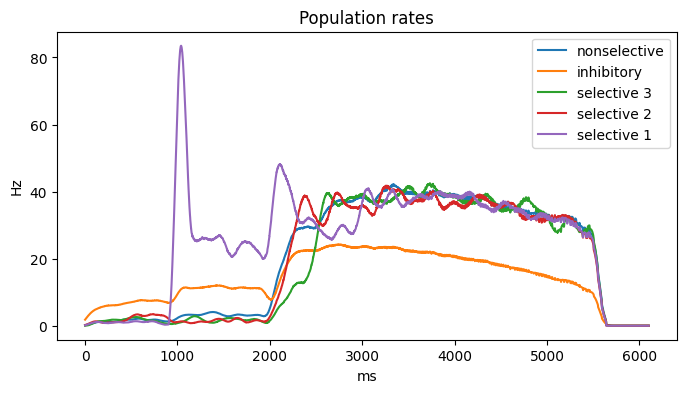

1152.0 (value to maximize)
0.2304 (Normalized value)


In [ ]:
result_dir = 'all_stored_results/ibnn_results/optimize_hypers'
updated_x, updated_y = shared_utils.get_latest_results(result_dir)
shared_utils.plot_best_results(updated_x, updated_y, objective_func_tensor)

In [ ]:
result_dir = 'all_stored_results/ibnn_results'
updated_x, updated_y = shared_utils.get_latest_results(result_dir)

In [ ]:
shared_utils.plot_best_results(updated_x, updated_y, objective_func_tensor)

## Turbo

In [ ]:
torch.set_printoptions(sci_mode=False)
dim = len(space)
stim_bounds = torch.tensor([[dim.low, dim.high] for dim in space], dtype=torch.float).T

result_dir='all_stored_results/turbo_results'
updated_x, updated_y = shared_utils.get_latest_results(result_dir)

In [ ]:
shared_utils.plot_best_results(updated_x, updated_y, objective_func_tensor)

## baseline BO

In [ ]:
result_dir = 'all_stored_results/bo_results'
updated_x, updated_y = shared_utils.get_latest_results(result_dir)

In [ ]:
shared_utils.plot_best_results(updated_x, updated_y, objective_func_tensor)

# Compare methods

## retrieve results

In [39]:
num_top_points = 20
all_methods = ['baseline', 'turbo', 'ibnn', 'cma']

results_dir_dict = {'baseline': 'all_stored_results/bo_results',
                    'turbo': 'all_stored_results/turbo_results',
                    'ibnn': 'all_stored_results/ibnn_results',
                    'cma': 'all_stored_results/cma_results'
                    }
x_dict, y_dict = shared_utils.load_top_optimization_results(results_dir_dict, stim_bounds, prefix='run_')


## plot iter vs value

In [ ]:
# process cma results to get the top points of each iteration's population
pop_size = 8
cma_x, cma_y = shared_utils.get_latest_results('all_stored_results/cma_results')
top_y_over_iter, top_params_over_iter, top_index_over_iter = cma_utils.separate_cma_results_by_pop(cma_x, cma_y , pop_size)
cum_top_index_over_iter = top_index_over_iter + np.arange(0, len(top_index_over_iter) * pop_size, pop_size)

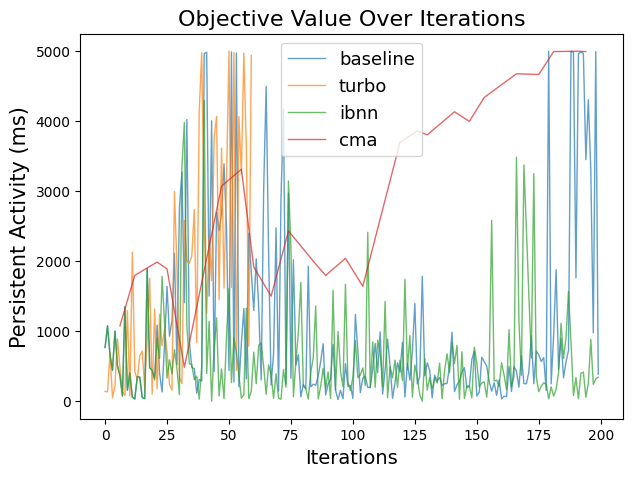

In [81]:
unnorm_factor = 5000
max_iter_to_plot = 200

all_methods = ['baseline', 'turbo', 'ibnn']
fig, ax = plt.subplots(figsize=(7, 5))
for method in all_methods:
    x_vals = x_dict[method]
    y_vals = y_dict[method] * unnorm_factor
    y_vals = y_vals[:max_iter_to_plot]
    ax.plot(range(len(y_vals)), y_vals, label=method, alpha=0.7, linewidth=1)

within_bounds = np.where(cum_top_index_over_iter < max_iter_to_plot)[0]
ax.plot(cum_top_index_over_iter[within_bounds], top_y_over_iter[within_bounds] * unnorm_factor, label='cma', alpha=0.7, linewidth=1)


ax.set_xlabel("Iterations", fontsize=14)
ax.set_ylabel("Persistent Activity (ms)", fontsize=15)
plt.title("Objective Value Over Iterations", fontsize=16)
ax.legend(fontsize=13)

plt.show()

## plot cum max

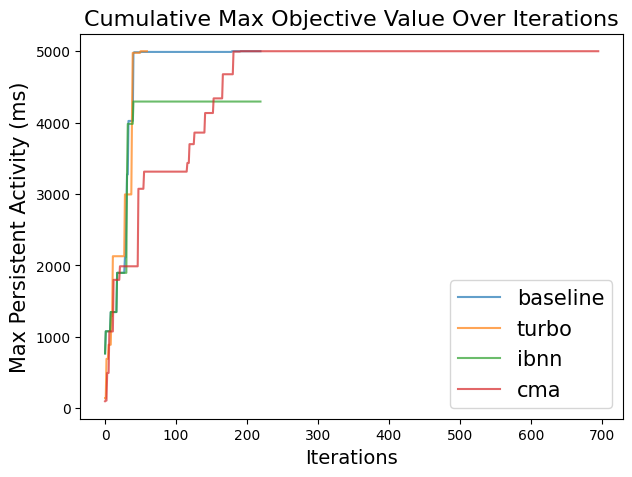

In [82]:
unnorm_factor = 5000
all_methods = ['baseline', 'turbo', 'ibnn', 'cma']

fig, ax = plt.subplots(figsize=(7, 5))
for method in all_methods:
    x_vals = x_dict[method]
    y_vals = y_dict[method] * unnorm_factor
    cum_max = (torch.cummax(y_vals, dim=0)[0]).cpu()
    ax.plot(range(len(cum_max)), cum_max, label=method, alpha=0.7, linewidth=1.5)

ax.set_xlabel("Iterations", fontsize=14)
ax.set_ylabel("Max Persistent Activity (ms)", fontsize=15)
ax.set_title("Cumulative Max Objective Value Over Iterations", fontsize=16)
ax.legend(fontsize=15)
plt.show()

## plot top param range

In [ ]:
# indices_to_plot = [2, 3, 6, 7]
indices_to_plot = range(8)
shared_utils.plot_top_param_distributions(space, x_dict, y_dict, indices_to_plot=indices_to_plot)

In [ ]:
pls_stop

# top 5 x 5

### iterate

In [ ]:
objective_func_tensor_temp = partial(obj_func_utils.objective_function, net=net, namespace=namespace, stim_bounds=stim_bounds, current_monitor_E=current_monitor_E, r_E=r_E, r_I=r_I, r_E_sels=r_E_sels,
                                process_input_func=obj_func_utils.process_input_tensor, process_output_func=obj_func_utils.process_output_tensor, E_index_map=E_index_map,
                                maximize=True, plotting=False)

x_rep_dict = {}
y_rep_dict = {}
verbose = True
prefix = 'run_'
num_repeats = 5
num_top_points = 10

for run in range(1, 6):
    method = f'turbo_{run}'
    try:
        if verbose:
            print(f"Method: {method}")

        updated_x = torch.load(os.path.join('all_stored_results/turbo_results', f"run_{run}/updated_x.pt"))
        updated_y = torch.load(os.path.join('all_stored_results/turbo_results', f"run_{run}/updated_y.pt"))
        'all_stored_results/turbo_results'

        all_best_params, all_values_reps = shared_utils.repeat_eval_top_params(
            updated_x, updated_y, objective_func_tensor_temp, method, num_top_points=num_top_points, num_repeats=num_repeats)

        x_rep_dict[method] = all_best_params
        y_rep_dict[method] = all_values_reps

    except Exception as e:
        if verbose:
            print(f"Failed to load results for method '{method}': {e}")

# avg_eval_df, all_averages = shared_utils.build_avg_eval_df(y_rep_dict, save_path='all_stored_results/compare_methods/avg_eval2.csv')
# repeated_eval_df = shared_utils.build_repeated_eval_df(y_rep_dict, save_path='all_stored_results/compare_methods/repeated_eval2.csv')

In [ ]:
results_dir_dict = {'baseline': 'all_stored_results/bo_results',
                    'turbo': 'all_stored_results/turbo_results',
                    'ibnn': 'all_stored_results/ibnn_results',
                    'ibnn_hypers': 'all_stored_results/ibnn_results/optimize_hypers',
                    'cma': 'all_stored_results/cma_results'
                    }

all_methods = ['baseline', 'ibnn', 'ibnn_hypers', 'cma']

# x_rep_dict = {}
# y_rep_dict = {}
verbose = True
prefix = 'run_'
num_repeats = 5
num_top_points = 10

for method in all_methods:
    result_dir = results_dir_dict[method]
    try:
        if verbose:
            print(f"Method: {method}")
        updated_x, updated_y = shared_utils.get_latest_results(result_dir)

        all_best_params, all_values_reps = shared_utils.repeat_eval_top_params(
            updated_x, updated_y, objective_func_tensor, method, num_top_points=num_top_points, num_repeats=num_repeats)

        x_rep_dict[method] = all_best_params
        y_rep_dict[method] = all_values_reps

    except Exception as e:
        if verbose:
            print(f"Failed to load results for method '{method}': {e}")

avg_eval_df, all_averages = shared_utils.build_avg_eval_df(y_rep_dict, save_path='all_stored_results/compare_methods/avg_eval2.csv')
repeated_eval_df = shared_utils.build_repeated_eval_df(y_rep_dict, save_path='all_stored_results/compare_methods/repeated_eval2.csv')

### compare average

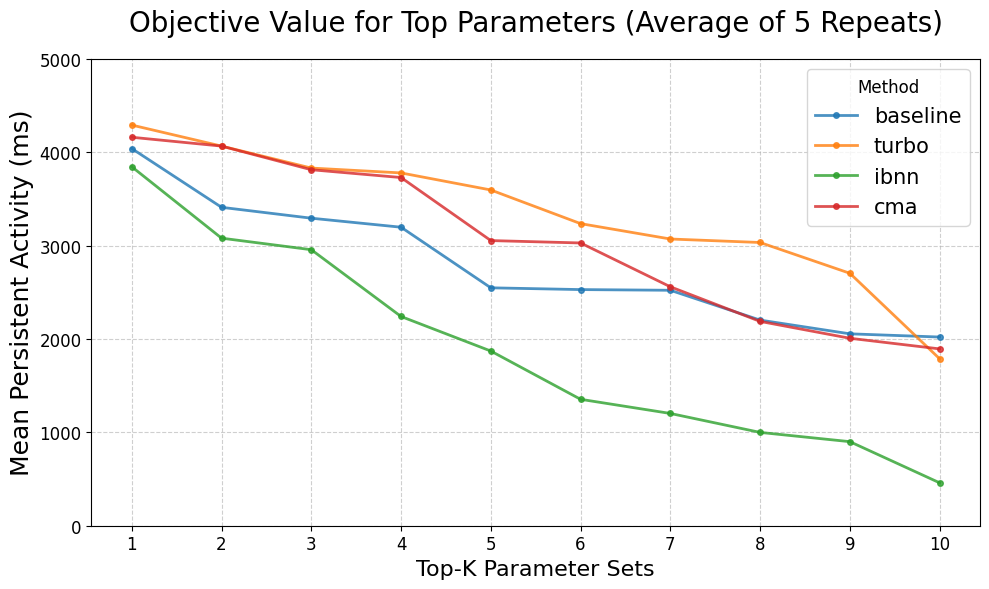

In [ ]:
avg_eval_df = pd.read_csv('all_stored_results/compare_methods/avg_eval.csv')
avg_eval_df_sorted = avg_eval_df.copy()
# for each column in all methods, sort the column in descending order
for method in all_methods:
    avg_eval_df_sorted[method] = avg_eval_df_sorted[method].sort_values(ascending=False).reset_index(drop=True)
shared_utils.plot_avg_eval_df(avg_eval_df_sorted, num_repeats=5)

### compare unsorted average

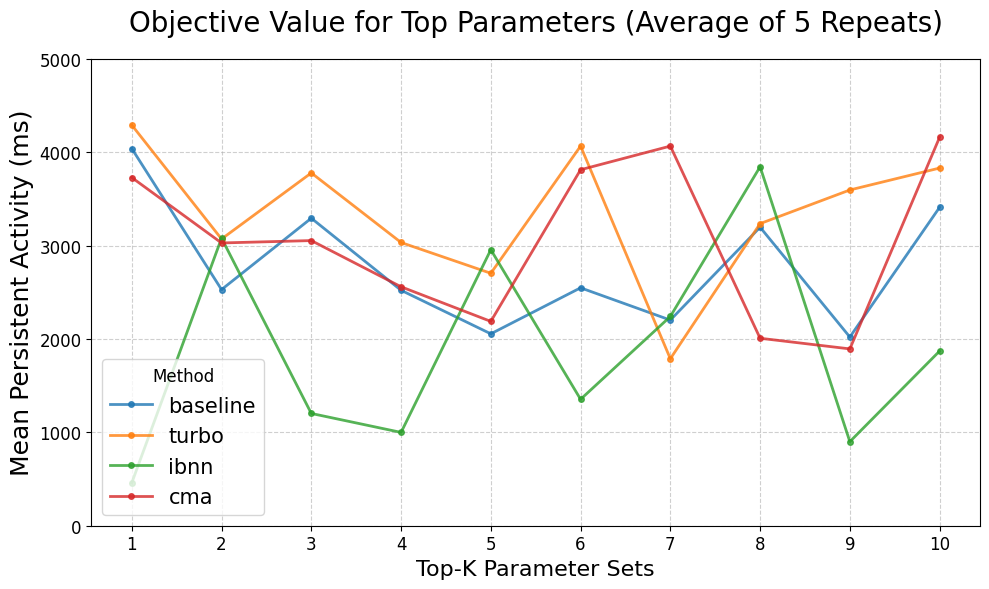

In [ ]:
avg_eval_df = pd.read_csv('all_stored_results/compare_methods/avg_eval.csv')
shared_utils.plot_avg_eval_df(avg_eval_df, num_repeats=5)

# Show CV top results

In [ ]:
top_results_params = {}
for method in all_methods:
    top_result_index = avg_eval_df[method].idxmax()
    top_results_params[method] = x_rep_dict[method][top_result_index]

In [85]:
avg_eval_df

,Top-K,baseline,turbo,ibnn,cma
0,0,0.807724,0.858032,0.091896,0.745660
1,1,0.505708,0.614020,0.615820,0.605552
2,2,0.658588,0.755540,0.240432,0.610656
3,3,0.504232,0.606544,0.199848,0.511704
4,4,0.410972,0.540644,0.591104,0.437560
5,5,0.509492,0.813004,0.270736,0.762368
6,6,0.440372,0.357592,0.448068,0.813012
7,7,0.639276,0.646956,0.768748,0.401468
8,8,0.404084,0.719020,0.180024,0.378688
9,9,0.681892,0.765976,0.374084,0.831920
